In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import math
from imutils import contours

In [4]:
input_image_path = 'Image/sheet_raw.jpg'
output_file = "yolo_coordinates.txt"

# Rotate

In [5]:
def find_top_left_and_top_right(points):
    """
    Xác định điểm top-left và top-right từ danh sách tọa độ YOLO.

    :param points: Danh sách tọa độ [(x1, y1), (x2, y2), ...] theo định dạng YOLO.
    :return: Tọa độ top-left và top-right.
    """
    # Sắp xếp các điểm theo giá trị y trước, nếu bằng thì theo x
    sorted_points = sorted(points, key=lambda p: (p[1], p[0]))

    # Top-left là điểm có x nhỏ nhất và y nhỏ nhất
    top_left = sorted_points[0]

    # Top-right là điểm có x lớn nhất và y nhỏ nhất
    top_right_candidates = [p for p in sorted_points if abs(p[1] - top_left[1]) < 0.01]  # Cùng hàng với top-left
    top_right = max(top_right_candidates, key=lambda p: p[0])  # Điểm có x lớn nhất

    return top_left, top_right

def find_angle(points):
    """
    Tính góc giữa đường nối top-left và top-right với trục x.

    :param points: Danh sách tọa độ [(x1, y1), (x2, y2), ...] theo định dạng YOLO.
    :return: Góc tính bằng độ.
    """
    # Xác định top-left và top-right
    top_left, top_right = find_top_left_and_top_right(points)

    # Tính góc dựa trên tọa độ
    delta_x = top_right[0] - top_left[0]
    delta_y = top_right[1] - top_left[1]
    angle = math.degrees(math.atan2(delta_y, delta_x))
    return angle

In [6]:
def rotate(image, angle, scale):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)

    # Tạo ma trận xoay
    M = cv2.getRotationMatrix2D(center, angle, scale)

    # Áp dụng ma trận xoay
    rotated_image = cv2.warpAffine(image, M, (w, h))

    return rotated_image

In [7]:
def detect_black_square_centers(image_path, output_path):
    """
    Detects black squares in a given image, saves the output, and displays numbered IDs.

    :param image_path: Path to the input image
    :param output_path: Path to the output image
    :return: List of centers of the black squares in YOLOv8 format
    """
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold để phát hiện vùng đen
    _, thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)

    # Tìm contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centers = []
    image_height, image_width = image.shape[:2]

    idx = 0  # Khởi tạo bộ đếm
    for contour in contours:
        epsilon = 0.04 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Kiểm tra contour có 4 đỉnh
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)

            # Kiểm tra tỉ lệ và kích thước khung hình
            if 0.9 < aspect_ratio < 1.1 and w > 20 and h > 20:
                roi = thresh[y:y+h, x:x+w]
                black_pixels = cv2.countNonZero(roi)
                total_pixels = w * h
                fill_ratio = black_pixels / total_pixels

                # Kiểm tra mật độ màu đen
                if fill_ratio > 0.9:
                    M = cv2.moments(contour)
                    if M["m00"] != 0:
                        center_x = int(M["m10"] / M["m00"])
                        center_y = int(M["m01"] / M["m00"])

                        yolov8_x = center_x / image_width
                        yolov8_y = center_y / image_height

                        centers.append((yolov8_x, yolov8_y))

                        # Vẽ hình tròn và rectangle
                        cv2.circle(image, (center_x, center_y), 5, (0, 0, 255), -1)
                        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

                        # Đánh số thứ tự và chỉ tăng idx khi điều kiện được thỏa mãn
                        idx += 1
                        cv2.putText(image, str(idx), (center_x - 10, center_y - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Lưu ảnh kết quả
    cv2.imwrite(output_path, image)
    print(f"Processed image saved to: {output_path}")
    print("Centers of black squares (YOLOv8 format):", centers)
    return centers

# Đường dẫn ảnh đầu vào và đầu ra
output_path = 'Image/sheet_saved_numbered.jpg'

# Gọi hàm và lưu kết quả
centers = detect_black_square_centers(input_image_path, output_path)


Processed image saved to: Image/sheet_saved_numbered.jpg
Centers of black squares (YOLOv8 format): [(0.9157427937915743, 0.928911456680419), (0.7707317073170732, 0.9247857822913361), (0.6283813747228382, 0.9216121866074262), (0.4878048780487805, 0.9190733100602984), (0.34767184035476717, 0.9174865122183434), (0.20709534368070953, 0.9165344335131704), (0.06607538802660753, 0.9152649952396065), (0.9152993348115299, 0.6708981275785465), (0.7725055432372505, 0.6686766105998095), (0.7015521064301552, 0.6677245318946367), (0.6310421286031042, 0.6667724531894637), (0.4909090909090909, 0.6651856553475087), (0.3507760532150776, 0.6642335766423357), (0.2811529933481153, 0.6635988575055538), (0.2106430155210643, 0.6632814979371628), (0.06873614190687362, 0.6620120596635989), (0.9170731707317074, 0.5445890193589337), (0.7033259423503326, 0.5420501428118057), (0.49223946784922396, 0.5401459854014599), (0.282039911308204, 0.5385591875595049), (0.06962305986696231, 0.536337670580768), (0.920620842572

Angle: 0.1492583199192713
Point 1: (0.9157427937915743, 0.928911456680419)
Point 2: (0.06607538802660753, 0.9152649952396065)
Point 3: (0.9254988913525499, 0.07489685814027293)
Point 4: (0.07272727272727272, 0.07267534116153603)


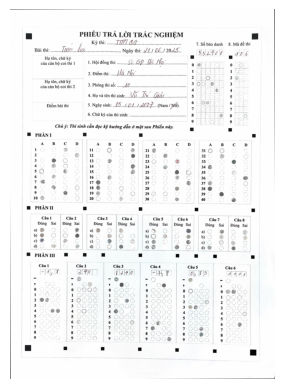

In [8]:
output_path = 'Image/sheet_rotate.jpg'
idx_list = [1, 7, 30, 31]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    centers[idx_list[3]-1],  # Point 4
]

angle = find_angle(points_of_interest)
image = cv2.imread(input_image_path)
image = rotate(image, angle, 1)

print("Angle:", angle)
for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

cv2.imwrite(output_path, image)

plt.imshow(image)
plt.axis('off')
plt.show()

In [9]:
# Đường dẫn ảnh đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_path = 'Image/sheet_saved_numbered.jpg'

# Gọi hàm và lưu kết quả
centers = detect_black_square_centers(input_image_path, output_path)

Processed image saved to: Image/sheet_saved_numbered.jpg
Centers of black squares (YOLOv8 format): [(0.9175166297117516, 0.9282767375436369), (0.7725055432372505, 0.924468422722945), (0.6297117516629712, 0.9212948270390352), (0.48957871396895786, 0.9190733100602984), (0.34944567627494455, 0.9178038717867344), (0.20842572062084258, 0.9168517930815614), (0.06784922394678493, 0.9158997143763884), (0.9157427937915743, 0.6702634084417646), (0.7733924611973393, 0.6683592510314186), (0.7019955654101996, 0.6670898127578546), (0.6314855875831485, 0.6664550936210727), (0.49135254988913524, 0.6651856553475087), (0.35121951219512193, 0.6645509362107268), (0.28159645232815966, 0.6639162170739448), (0.21108647450110865, 0.6635988575055538), (0.06917960088691796, 0.6626467788003808), (0.9175166297117516, 0.5436369406537607), (0.7033259423503326, 0.5417327832434148), (0.49223946784922396, 0.5401459854014599), (0.282039911308204, 0.5388765471278959), (0.07006651884700665, 0.53697238971755), (0.91973392

# Crop and fix coordinate

In [10]:
final_coordinate = []
input_image_path = 'Image/sheet_rotate.jpg'
image = cv2.imread(input_image_path)
height, width = image.shape[:2]

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def draw_boxes_with_matplotlib(image_path, yolo_boxes, output_path=None):
    """
    Draws rectangles on the image using YOLO coordinates and displays it with matplotlib.

    :param image_path: Path to the input image
    :param yolo_boxes: List of YOLO format boxes [(center_x, center_y, width, height), ...]
    :param output_path: Path to save the output image (optional)
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    h, w = image.shape[:2]

    # Draw rectangles on the image
    for box in yolo_boxes:
        center_x, center_y, box_width, box_height = box
        x1 = int((center_x - box_width / 2) * w)
        y1 = int((center_y - box_height / 2) * h)
        x2 = int((center_x + box_width / 2) * w)
        y2 = int((center_y + box_height / 2) * h)

        # Draw rectangle
        image = cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Save the result (optional)
    if output_path:
        cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        print(f"Output image saved to {output_path}")

    # Display the image using matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title("Image with Boxes")
    plt.axis("off")
    plt.show()

def generate_grid_coordinates(start_coord, grid_size, cell_spacing):
    """
    Generate a grid of bounding boxes based on the starting YOLO coordinate.

    :param start_coord: Tuple (center_x, center_y, width, height) of the top-left box (YOLO format)
    :param grid_size: Tuple (rows, cols) indicating the size of the grid (e.g., (6, 10))
    :param cell_spacing: Tuple (x_spacing, y_spacing) indicating spacing between boxes (YOLO format)
    :return: List of bounding boxes in YOLO format [(center_x, center_y, width, height), ...]
    """
    center_x, center_y, width, height = start_coord
    rows, cols = grid_size
    x_spacing, y_spacing = cell_spacing

    # Create grid coordinates
    grid_coords = []
    for row in range(rows):
        for col in range(cols):
            new_center_x = center_x + col * (width + x_spacing)
            new_center_y = center_y + row * (height + y_spacing)
            grid_coords.append((new_center_x, new_center_y, width, height))

    return grid_coords


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def cut_image_from_points(image_path, points, output_path):
    """
    Cuts a region of the image using 4 specific points without resizing and displays it.

    :param image_path: Path to the input image
    :param points: List of 4 specific points [(x, y), ...] in normalized coordinates (YOLO format)
    :param output_path: Path to save the cropped image
    """
    # Đọc ảnh gốc
    image = cv2.imread(image_path)

    # Lấy kích thước ảnh
    image_height, image_width = image.shape[:2]

    # Chuyển đổi tọa độ từ normalized (YOLO format) sang pixel
    pixel_points = np.array([
        [int(point[0] * image_width), int(point[1] * image_height)]
        for point in points
    ], dtype=np.int32)

    # Tính bounding box (tọa độ tối thiểu và tối đa)
    x_min, y_min = np.min(pixel_points, axis=0)
    x_max, y_max = np.max(pixel_points, axis=0)

    # Cắt ảnh từ bounding box
    cropped_image = image[y_min:y_max, x_min:x_max]
    print(f"Cropped image shape: {cropped_image.shape}")

    # Lưu ảnh đã cắt
    cv2.imwrite(output_path, cropped_image)
    print(f"Cropped image saved to: {output_path}")

    # Hiển thị ảnh bằng matplotlib
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.title("Cropped Region")
    plt.axis("off")
    plt.show()

    return x_min, y_min, x_max, y_max

## SBD

In [13]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/SBD.jpg'
output_annote_path = 'Image/Processed_Image/SBD.jpg'

Point 1: (0.6873614190687362, 0.12980006347191367)
Point 2: (0.8323725055432373, 0.13011742304030466)
Point 3: (0.6855875831485587, 0.32497619803237066)
Point 4: (0.8301552106430156, 0.3262456363059346)
Cropped image shape: (620, 331, 3)
Cropped image saved to: Image/Crop_Image/SBD.jpg


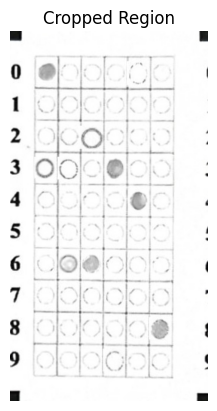

In [14]:
idx_list = [29, 28, 27, 26]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    centers[idx_list[3]-1],  # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/SBD.jpg


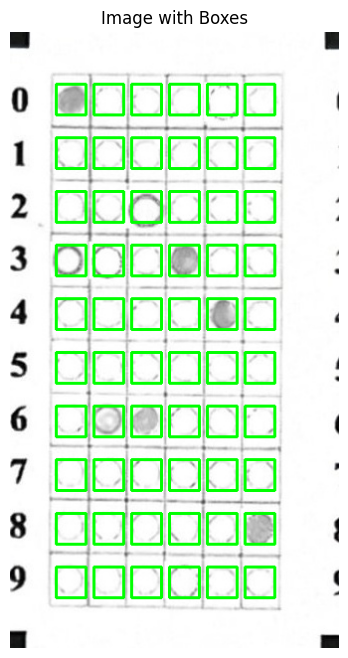

In [15]:
# Input details
start_coord = (0.185, 0.11, 0.09, 0.05)  # Top-left box in YOLO format
grid_size = (10, 6)  # 10 rows, 6 columns
cell_spacing = (0.025, 0.037)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(output_cut_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

In [16]:
print(final_coordinate)

[(1607.235, 476.2, 29, 31.0), (1645.3, 476.2, 29, 31.0), (1683.365, 476.2, 29, 31.0), (1721.43, 476.2, 29, 31.0), (1759.495, 476.2, 29, 31.0), (1797.56, 476.2, 29, 31.0), (1607.235, 530.14, 29, 31.0), (1645.3, 530.14, 29, 31.0), (1683.365, 530.14, 29, 31.0), (1721.43, 530.14, 29, 31.0), (1759.495, 530.14, 29, 31.0), (1797.56, 530.14, 29, 31.0), (1607.235, 584.0799999999999, 29, 31.0), (1645.3, 584.0799999999999, 29, 31.0), (1683.365, 584.0799999999999, 29, 31.0), (1721.43, 584.0799999999999, 29, 31.0), (1759.495, 584.0799999999999, 29, 31.0), (1797.56, 584.0799999999999, 29, 31.0), (1607.235, 638.02, 29, 31.0), (1645.3, 638.02, 29, 31.0), (1683.365, 638.02, 29, 31.0), (1721.43, 638.02, 29, 31.0), (1759.495, 638.02, 29, 31.0), (1797.56, 638.02, 29, 31.0), (1607.235, 691.96, 29, 31.0), (1645.3, 691.96, 29, 31.0), (1683.365, 691.96, 29, 31.0), (1721.43, 691.96, 29, 31.0), (1759.495, 691.96, 29, 31.0), (1797.56, 691.96, 29, 31.0), (1607.235, 745.9, 29, 31.0), (1645.3, 745.9, 29, 31.0), (16

In [17]:
print(yolo_boxes)

[(0.185, 0.11, 0.09, 0.05), (0.3, 0.11, 0.09, 0.05), (0.415, 0.11, 0.09, 0.05), (0.53, 0.11, 0.09, 0.05), (0.645, 0.11, 0.09, 0.05), (0.76, 0.11, 0.09, 0.05), (0.185, 0.197, 0.09, 0.05), (0.3, 0.197, 0.09, 0.05), (0.415, 0.197, 0.09, 0.05), (0.53, 0.197, 0.09, 0.05), (0.645, 0.197, 0.09, 0.05), (0.76, 0.197, 0.09, 0.05), (0.185, 0.284, 0.09, 0.05), (0.3, 0.284, 0.09, 0.05), (0.415, 0.284, 0.09, 0.05), (0.53, 0.284, 0.09, 0.05), (0.645, 0.284, 0.09, 0.05), (0.76, 0.284, 0.09, 0.05), (0.185, 0.371, 0.09, 0.05), (0.3, 0.371, 0.09, 0.05), (0.415, 0.371, 0.09, 0.05), (0.53, 0.371, 0.09, 0.05), (0.645, 0.371, 0.09, 0.05), (0.76, 0.371, 0.09, 0.05), (0.185, 0.45799999999999996, 0.09, 0.05), (0.3, 0.45799999999999996, 0.09, 0.05), (0.415, 0.45799999999999996, 0.09, 0.05), (0.53, 0.45799999999999996, 0.09, 0.05), (0.645, 0.45799999999999996, 0.09, 0.05), (0.76, 0.45799999999999996, 0.09, 0.05), (0.185, 0.5449999999999999, 0.09, 0.05), (0.3, 0.5449999999999999, 0.09, 0.05), (0.415, 0.54499999999

## MDT

In [18]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/MDT.jpg'
output_annote_path = 'Image/Processed_Image/MDT.jpg'

Point 1: (0.8323725055432373, 0.13011742304030466)
Point 2: (0.8301552106430156, 0.3262456363059346)
Point 3: (0.9223725055432372, 0.13011742304030466)
Point 4: (0.9201552106430155, 0.3262456363059346)
Cropped image shape: (618, 207, 3)
Cropped image saved to: Image/Crop_Image/MDT.jpg


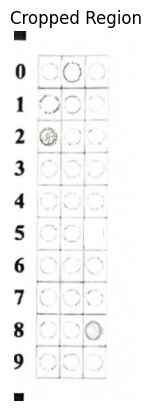

In [19]:
idx_list = [28, 26]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    (centers[idx_list[0]-1][0]+0.09, centers[idx_list[0]-1][1]),  # Point 3
    (centers[idx_list[1]-1][0]+0.09, centers[idx_list[1]-1][1])   # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/MDT.jpg


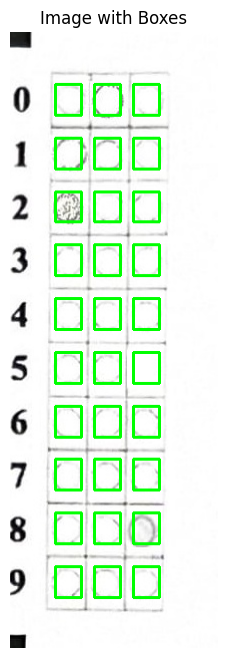

In [20]:
# Input details
start_coord = (0.28, 0.11, 0.125, 0.05)  # Top-left box in YOLO format
grid_size = (10, 3)  # 10 rows, 3 columns
cell_spacing = (0.063, 0.037)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)

# Input image and output paths
input_image_path = 'Image/MDT.jpg'

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(input_image_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

## Phan 1_1

In [21]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/Phan1_1.jpg'
output_annote_path = 'Image/Processed_Image/Phan1_1.jpg'

Point 1: (0.07139689578713969, 0.33830529990479213)
Point 2: (0.28159645232815966, 0.3389400190415741)
Point 3: (0.282039911308204, 0.5388765471278959)
Point 4: (0.07006651884700665, 0.53697238971755)
Cropped image shape: (632, 478, 3)
Cropped image saved to: Image/Crop_Image/Phan1_1.jpg


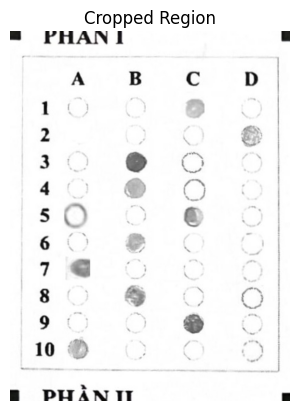

In [22]:
idx_list = [25, 24, 20, 21]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    centers[idx_list[3]-1],  # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/Phan1_1.jpg


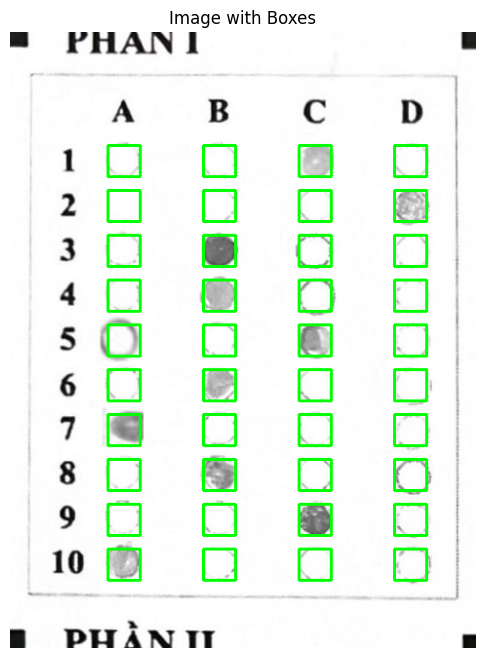

In [23]:
# Input details
start_coord = (0.245, 0.21, 0.07, 0.05)  # Top-left box in YOLO format
grid_size = (10, 4)  # 10 rows, 4 columns
cell_spacing = (0.135, 0.0227)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(output_cut_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

## Phan 1_2

In [24]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/Phan1_2.jpg'
output_annote_path = 'Image/Processed_Image/Phan1_2.jpg'

Point 1: (0.4931263858093126, 0.34052681688352904)
Point 2: (0.28159645232815966, 0.3389400190415741)
Point 3: (0.282039911308204, 0.5388765471278959)
Point 4: (0.49223946784922396, 0.5401459854014599)
Cropped image shape: (634, 477, 3)
Cropped image saved to: Image/Crop_Image/Phan1_2.jpg


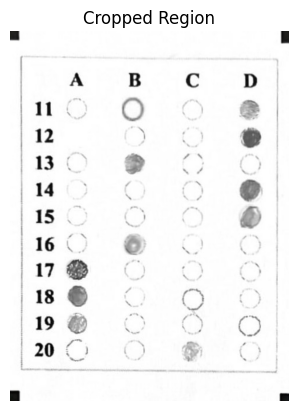

In [25]:
idx_list = [23, 24, 20, 19]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    centers[idx_list[3]-1],  # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/Phan1_2.jpg


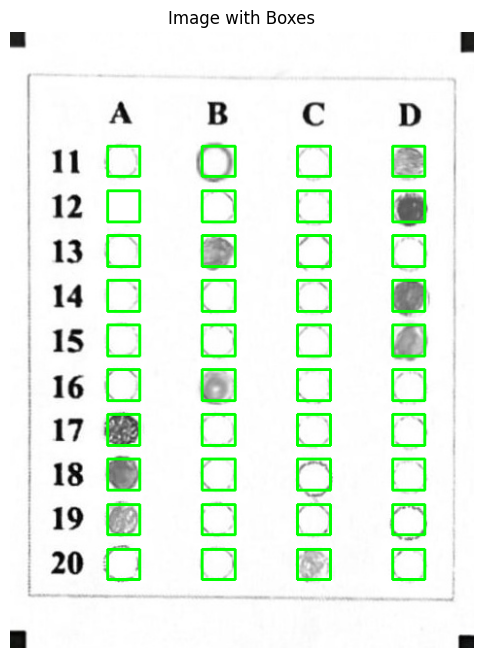

In [26]:
# Input details
start_coord = (0.245, 0.21, 0.07, 0.05)  # Top-left box in YOLO format
grid_size = (10, 4)  # 10 rows, 4 columns
cell_spacing = (0.135, 0.0227)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(output_cut_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

## Phan 1_3

In [27]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/Phan1_3.jpg'
output_annote_path = 'Image/Processed_Image/Phan1_3.jpg'

Point 1: (0.4931263858093126, 0.34052681688352904)
Point 2: (0.7033259423503326, 0.5417327832434148)
Point 3: (0.49223946784922396, 0.5401459854014599)
Point 4: (0.7033259423503326, 0.34052681688352904)
Cropped image shape: (634, 476, 3)
Cropped image saved to: Image/Crop_Image/Phan1_3.jpg


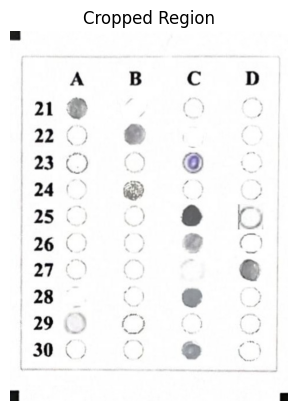

In [28]:
idx_list = [23, 18, 19]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    #centers[idx_list[3]-1],  # Point 4
    (centers[idx_list[1]-1][0], centers[idx_list[0]-1][1])   # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/Phan1_3.jpg


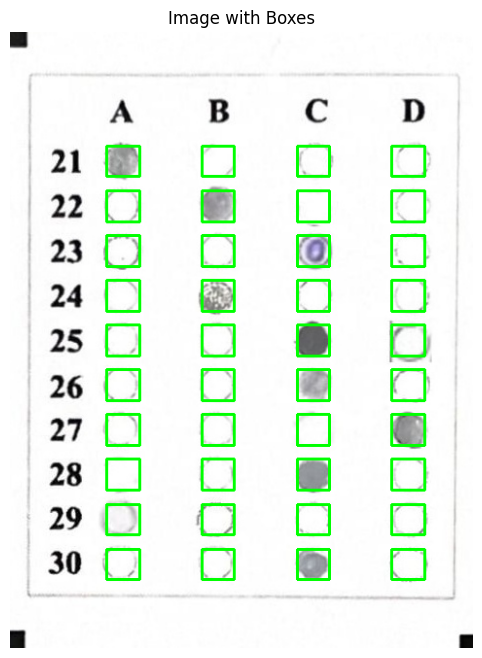

In [29]:
# Input details
start_coord = (0.245, 0.21, 0.07, 0.05)  # Top-left box in YOLO format
grid_size = (10, 4)  # 10 rows, 4 columns
cell_spacing = (0.135, 0.0227)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(output_cut_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

## Phan 1_4

In [30]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/Phan1_4.jpg'
output_annote_path = 'Image/Processed_Image/Phan1_4.jpg'

Point 1: (0.9197339246119733, 0.34211361472548396)
Point 2: (0.7033259423503326, 0.5417327832434148)
Point 3: (0.9175166297117516, 0.5436369406537607)
Point 4: (0.7033259423503326, 0.34211361472548396)
Cropped image shape: (634, 488, 3)
Cropped image saved to: Image/Crop_Image/Phan1_4.jpg


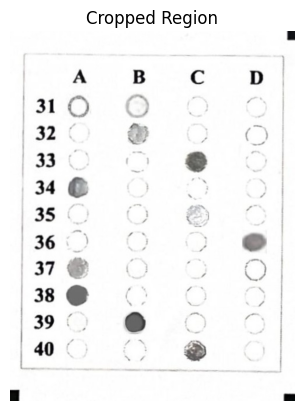

In [31]:
idx_list = [22, 18, 17]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    #centers[idx_list[3]-1],  # Point 4
    (centers[idx_list[1]-1][0], centers[idx_list[0]-1][1])   # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/Phan1_4.jpg


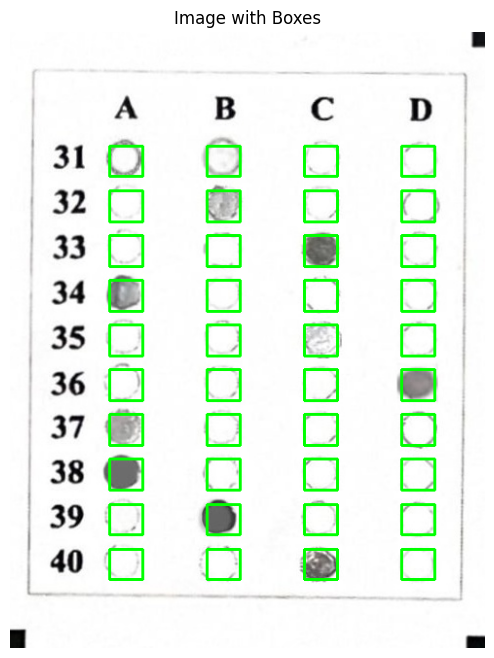

In [32]:
# Input details
start_coord = (0.245, 0.21, 0.07, 0.05)  # Top-left box in YOLO format
grid_size = (10, 4)  # 10 rows, 4 columns
cell_spacing = (0.135, 0.0227)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(output_cut_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

## Phan 2_1

In [33]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/Phan2_1.jpg'
output_annote_path = 'Image/Processed_Image/Phan2_1.jpg'

Point 1: (0.07006651884700665, 0.53697238971755)
Point 2: (0.282039911308204, 0.5388765471278959)
Point 3: (0.28159645232815966, 0.6639162170739448)
Point 4: (0.06917960088691796, 0.6626467788003808)
Cropped image shape: (400, 480, 3)
Cropped image saved to: Image/Crop_Image/Phan2_1.jpg


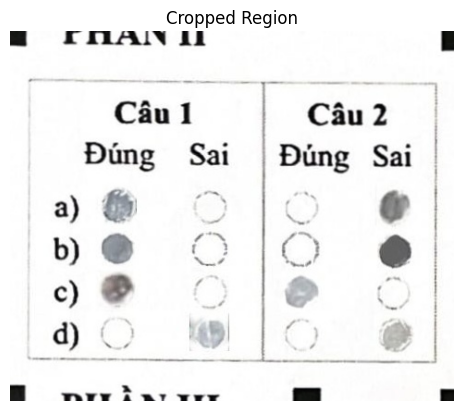

In [34]:
idx_list = [21, 20, 14, 16]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    centers[idx_list[3]-1],  # Point 4
    #(centers[idx_list[1]-1][0], centers[idx_list[0]-1][1])   # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/Phan2_1.jpg


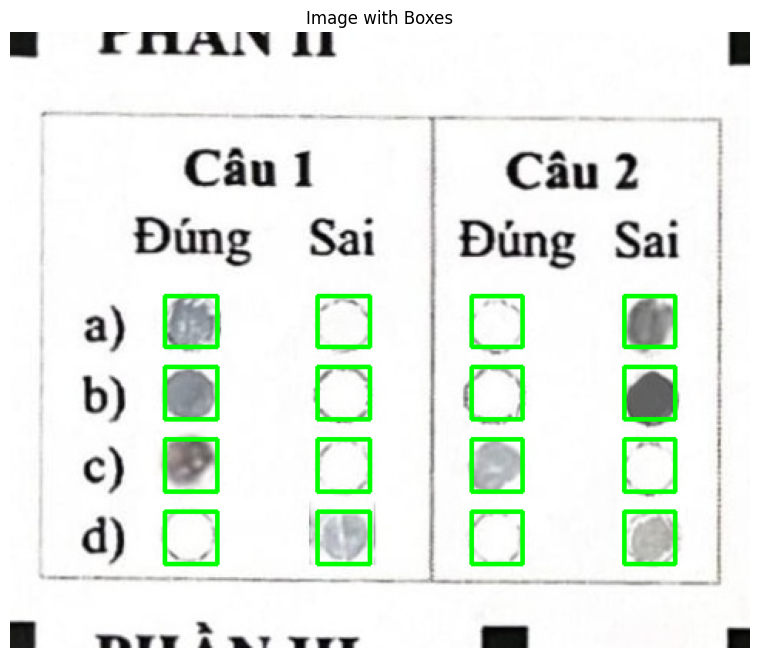

In [35]:
# Input details
start_coord = (0.245, 0.47, 0.07, 0.085)  # Top-left box in YOLO format
grid_size = (4, 4)  # 4 rows, 4 columns
cell_spacing = (0.1365, 0.032)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(output_cut_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

## Phan 2_2

In [36]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/Phan2_2.jpg'
output_annote_path = 'Image/Processed_Image/Phan2_2.jpg'

Point 1: (0.49223946784922396, 0.5401459854014599)
Point 2: (0.282039911308204, 0.5388765471278959)
Point 3: (0.28159645232815966, 0.6639162170739448)
Point 4: (0.49135254988913524, 0.6651856553475087)
Cropped image shape: (398, 475, 3)
Cropped image saved to: Image/Crop_Image/Phan2_2.jpg


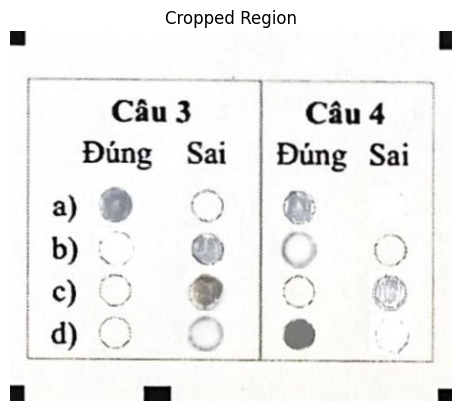

In [37]:
idx_list = [19, 20, 14, 12]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    centers[idx_list[3]-1],  # Point 4
    #(centers[idx_list[1]-1][0], centers[idx_list[0]-1][1])   # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/Phan2_2.jpg


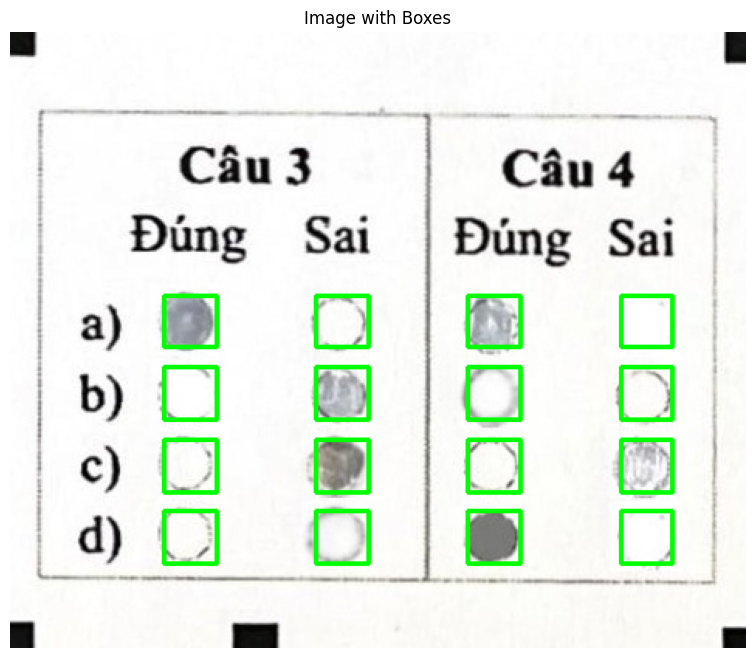

In [38]:
# Input details
start_coord = (0.245, 0.47, 0.07, 0.085)  # Top-left box in YOLO format
grid_size = (4, 4)  # 4 rows, 4 columns
cell_spacing = (0.1365, 0.032)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(output_cut_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

## Phan 2_3

In [39]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/Phan2_3.jpg'
output_annote_path = 'Image/Processed_Image/Phan2_3.jpg'

Point 1: (0.49223946784922396, 0.5401459854014599)
Point 2: (0.7033259423503326, 0.5417327832434148)
Point 3: (0.7019955654101996, 0.6670898127578546)
Point 4: (0.49135254988913524, 0.6651856553475087)
Cropped image shape: (400, 478, 3)
Cropped image saved to: Image/Crop_Image/Phan2_3.jpg


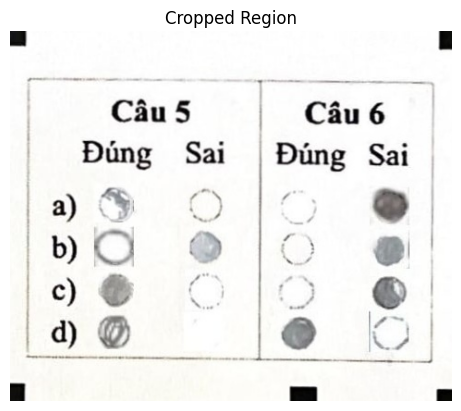

In [40]:
idx_list = [19, 18, 10, 12]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    centers[idx_list[3]-1],  # Point 4
    #(centers[idx_list[1]-1][0], centers[idx_list[0]-1][1])   # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/Phan2_3.jpg


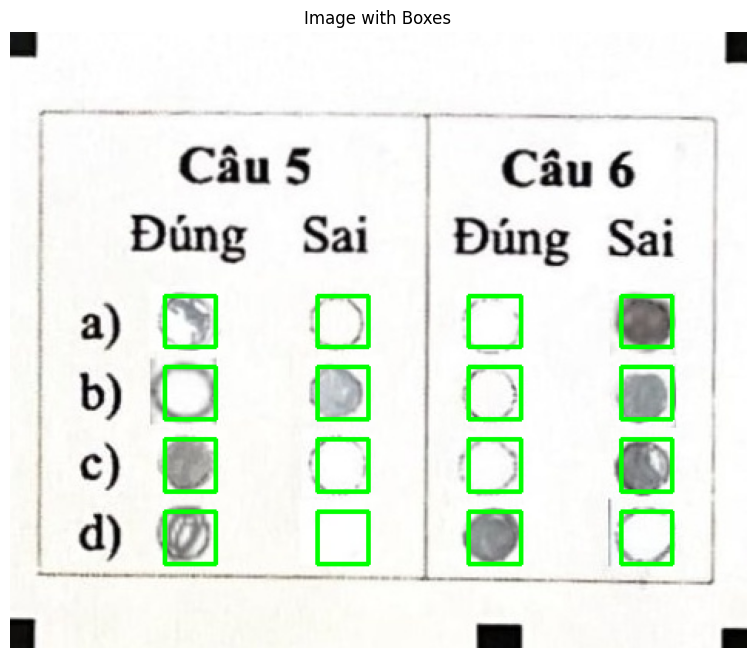

In [41]:
# Input details
start_coord = (0.245, 0.47, 0.07, 0.085)  # Top-left box in YOLO format
grid_size = (4, 4)  # 4 rows, 4 columns
cell_spacing = (0.1365, 0.032)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(output_cut_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

## Phan 2_4

In [42]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/Phan2_4.jpg'
output_annote_path = 'Image/Processed_Image/Phan2_4.jpg'

Point 1: (0.9175166297117516, 0.5436369406537607)
Point 2: (0.7033259423503326, 0.5417327832434148)
Point 3: (0.7019955654101996, 0.6670898127578546)
Point 4: (0.9157427937915743, 0.6702634084417646)
Cropped image shape: (405, 486, 3)
Cropped image saved to: Image/Crop_Image/Phan2_4.jpg


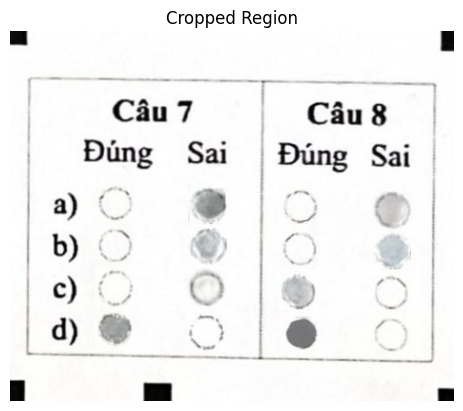

In [43]:
idx_list = [17, 18, 10, 8]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    centers[idx_list[3]-1],  # Point 4
    #(centers[idx_list[1]-1][0], centers[idx_list[0]-1][1])   # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/Phan2_4.jpg


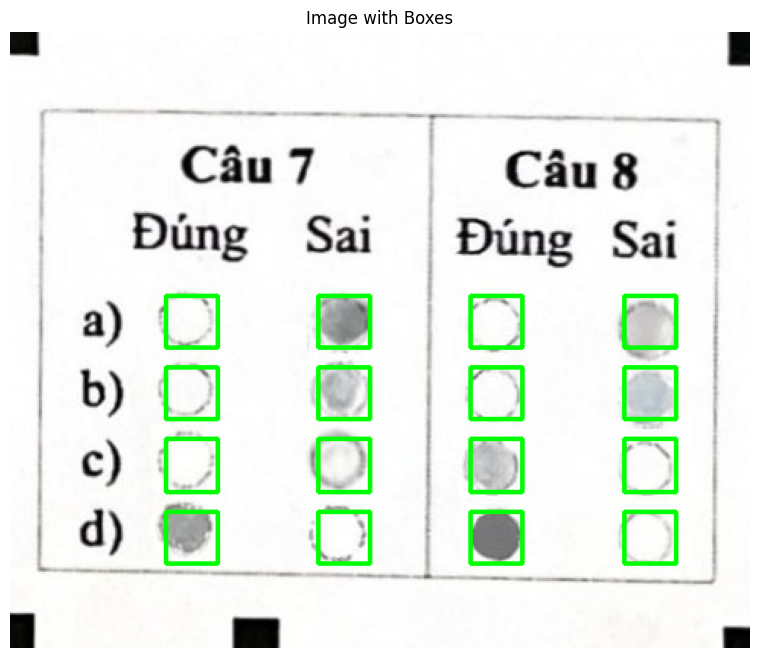

In [44]:
# Input details
start_coord = (0.245, 0.47, 0.07, 0.085)  # Top-left box in YOLO format
grid_size = (4, 4)  # 4 rows, 4 columns
cell_spacing = (0.1365, 0.032)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(output_cut_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

## Phan 3_1

In [45]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/Phan3_1.jpg'
output_annote_path = 'Image/Processed_Image/Phan3_1.jpg'

Point 1: (0.06917960088691796, 0.6626467788003808)
Point 2: (0.21108647450110865, 0.6635988575055538)
Point 3: (0.06784922394678493, 0.9158997143763884)
Point 4: (0.20842572062084258, 0.9168517930815614)
Cropped image shape: (801, 323, 3)
Cropped image saved to: Image/Crop_Image/Phan3_1.jpg


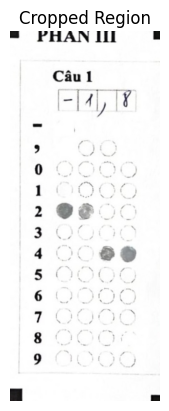

In [46]:
idx_list = [16, 15, 7, 6]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    centers[idx_list[3]-1],  # Point 4
    #(centers[idx_list[1]-1][0], centers[idx_list[0]-1][1])   # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/Phan3_1.jpg


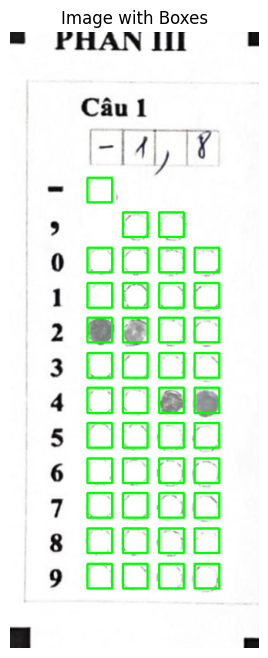

In [47]:
# Input details
start_coord = (0.36, 0.37, 0.1, 0.04)  # Top-left box in YOLO format
grid_size = (10, 4)  # 10 rows, 4 columns
cell_spacing = (0.044, 0.017)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)
yolo_boxes.append((0.36, 0.37-(0.04+0.017)*2, 0.1, 0.04))
yolo_boxes.append((0.36+(0.1+0.044), 0.37-(0.04+0.017), 0.1, 0.04))
yolo_boxes.append((0.36+(0.1+0.044)*2, 0.37-(0.04+0.017), 0.1, 0.04))

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(output_cut_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

## Phan 3_2

In [48]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/Phan3_2.jpg'
output_annote_path = 'Image/Processed_Image/Phan3_2.jpg'

Point 1: (0.35121951219512193, 0.6645509362107268)
Point 2: (0.21108647450110865, 0.6635988575055538)
Point 3: (0.34944567627494455, 0.9178038717867344)
Point 4: (0.20842572062084258, 0.9168517930815614)
Cropped image shape: (801, 322, 3)
Cropped image saved to: Image/Crop_Image/Phan3_2.jpg


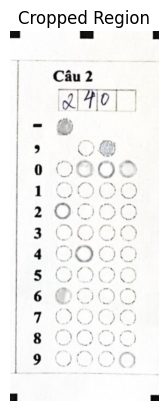

In [49]:
idx_list = [13, 15, 5, 6]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    centers[idx_list[3]-1],  # Point 4
    #(centers[idx_list[1]-1][0], centers[idx_list[0]-1][1])   # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/Phan3_2.jpg


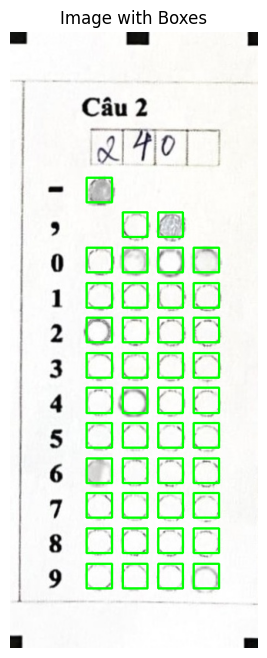

In [50]:
# Input details
start_coord = (0.36, 0.37, 0.1, 0.04)  # Top-left box in YOLO format
grid_size = (10, 4)  # 10 rows, 4 columns
cell_spacing = (0.044, 0.017)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)
yolo_boxes.append((0.36, 0.37-(0.04+0.017)*2, 0.1, 0.04))
yolo_boxes.append((0.36+(0.1+0.044), 0.37-(0.04+0.017), 0.1, 0.04))
yolo_boxes.append((0.36+(0.1+0.044)*2, 0.37-(0.04+0.017), 0.1, 0.04))

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(output_cut_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

## Phan 3_3

In [51]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/Phan3_3.jpg'
output_annote_path = 'Image/Processed_Image/Phan3_3.jpg'

Point 1: (0.35121951219512193, 0.6645509362107268)
Point 2: (0.49135254988913524, 0.6651856553475087)
Point 3: (0.34944567627494455, 0.9178038717867344)
Point 4: (0.48957871396895786, 0.9190733100602984)
Cropped image shape: (802, 320, 3)
Cropped image saved to: Image/Crop_Image/Phan3_3.jpg


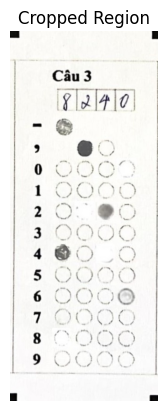

In [52]:
idx_list = [13, 12, 5, 4]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    centers[idx_list[3]-1],  # Point 4
    #(centers[idx_list[1]-1][0], centers[idx_list[0]-1][1])   # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/Phan3_3.jpg


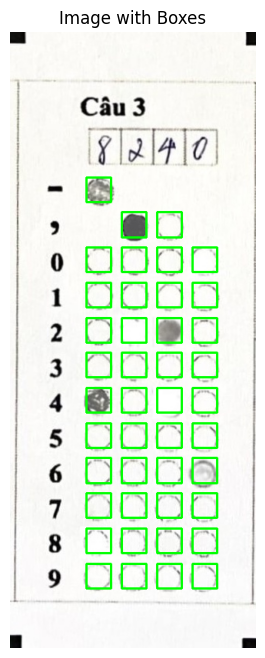

In [53]:
# Input details
start_coord = (0.36, 0.37, 0.1, 0.04)  # Top-left box in YOLO format
grid_size = (10, 4)  # 10 rows, 4 columns
cell_spacing = (0.044, 0.017)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)
yolo_boxes.append((0.36, 0.37-(0.04+0.017)*2, 0.1, 0.04))
yolo_boxes.append((0.36+(0.1+0.044), 0.37-(0.04+0.017), 0.1, 0.04))
yolo_boxes.append((0.36+(0.1+0.044)*2, 0.37-(0.04+0.017), 0.1, 0.04))

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(output_cut_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

## Phan 3_4

In [54]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/Phan3_4.jpg'
output_annote_path = 'Image/Processed_Image/Phan3_4.jpg'

Point 1: (0.6314855875831485, 0.6664550936210727)
Point 2: (0.49135254988913524, 0.6651856553475087)
Point 3: (0.6297117516629712, 0.9212948270390352)
Point 4: (0.48957871396895786, 0.9190733100602984)
Cropped image shape: (807, 320, 3)
Cropped image saved to: Image/Crop_Image/Phan3_4.jpg


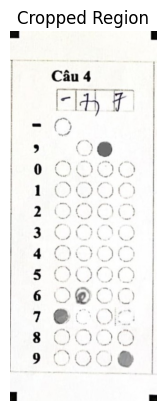

In [55]:
idx_list = [11, 12, 3, 4]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    centers[idx_list[3]-1],  # Point 4
    #(centers[idx_list[1]-1][0], centers[idx_list[0]-1][1])   # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/Phan3_4.jpg


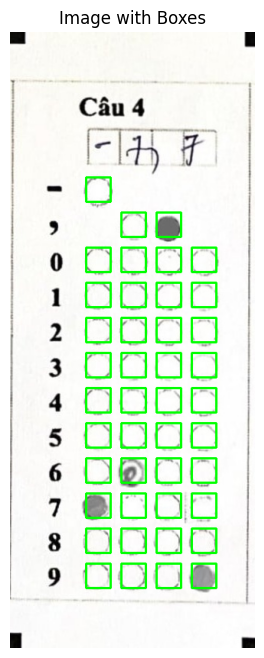

In [56]:
# Input details
start_coord = (0.36, 0.37, 0.1, 0.04)  # Top-left box in YOLO format
grid_size = (10, 4)  # 10 rows, 4 columns
cell_spacing = (0.044, 0.017)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)
yolo_boxes.append((0.36, 0.37-(0.04+0.017)*2, 0.1, 0.04))
yolo_boxes.append((0.36+(0.1+0.044), 0.37-(0.04+0.017), 0.1, 0.04))
yolo_boxes.append((0.36+(0.1+0.044)*2, 0.37-(0.04+0.017), 0.1, 0.04))

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(output_cut_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

## Phan 3_5

In [57]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/Phan3_5.jpg'
output_annote_path = 'Image/Processed_Image/Phan3_5.jpg'

Point 1: (0.6314855875831485, 0.6664550936210727)
Point 2: (0.7733924611973393, 0.6683592510314186)
Point 3: (0.6297117516629712, 0.9212948270390352)
Point 4: (0.7725055432372505, 0.924468422722945)
Cropped image shape: (813, 324, 3)
Cropped image saved to: Image/Crop_Image/Phan3_5.jpg


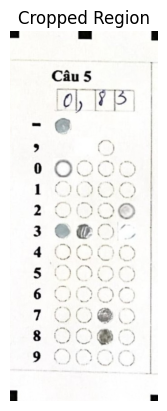

In [58]:
idx_list = [11, 9, 3, 2]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    centers[idx_list[3]-1],  # Point 4
    #(centers[idx_list[1]-1][0], centers[idx_list[0]-1][1])   # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/Phan3_5.jpg


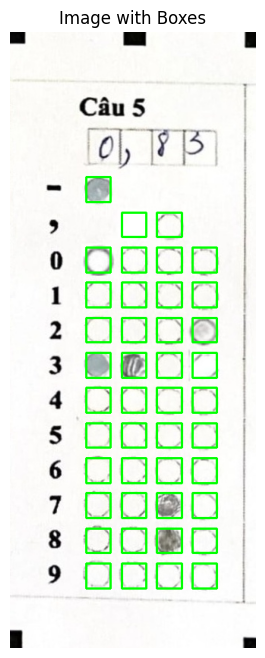

In [59]:
# Input details
start_coord = (0.36, 0.37, 0.1, 0.04)  # Top-left box in YOLO format
grid_size = (10, 4)  # 10 rows, 4 columns
cell_spacing = (0.044, 0.017)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)
yolo_boxes.append((0.36, 0.37-(0.04+0.017)*2, 0.1, 0.04))
yolo_boxes.append((0.36+(0.1+0.044), 0.37-(0.04+0.017), 0.1, 0.04))
yolo_boxes.append((0.36+(0.1+0.044)*2, 0.37-(0.04+0.017), 0.1, 0.04))

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(output_cut_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

## Phan 3_6

In [60]:
# Đường dẫn đầu vào và đầu ra
input_image_path = 'Image/sheet_rotate.jpg'
output_cut_path = 'Image/Crop_Image/Phan3_6.jpg'
output_annote_path = 'Image/Processed_Image/Phan3_6.jpg'

Point 1: (0.9157427937915743, 0.6702634084417646)
Point 2: (0.7733924611973393, 0.6683592510314186)
Point 3: (0.9175166297117516, 0.9282767375436369)
Point 4: (0.7725055432372505, 0.924468422722945)
Cropped image shape: (819, 327, 3)
Cropped image saved to: Image/Crop_Image/Phan3_6.jpg


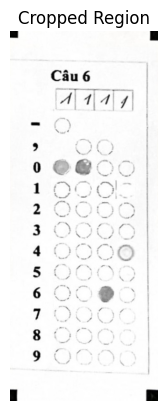

In [61]:
idx_list = [8, 9, 1, 2]

# 4 tọa độ cụ thể (YOLO normalized format)
points_of_interest = [
    centers[idx_list[0]-1],  # Point 1
    centers[idx_list[1]-1],  # Point 2
    centers[idx_list[2]-1],  # Point 3
    centers[idx_list[3]-1],  # Point 4
    #(centers[idx_list[1]-1][0], centers[idx_list[0]-1][1])   # Point 4
]

for idx, point in enumerate(points_of_interest, start=1):
    print(f"Point {idx}: {point}")

# Gọi hàm cắt ảnh không resize
x_min, y_min, x_max, y_max = cut_image_from_points(input_image_path, points_of_interest, output_cut_path)

Output image saved to Image/Processed_Image/Phan3_6.jpg


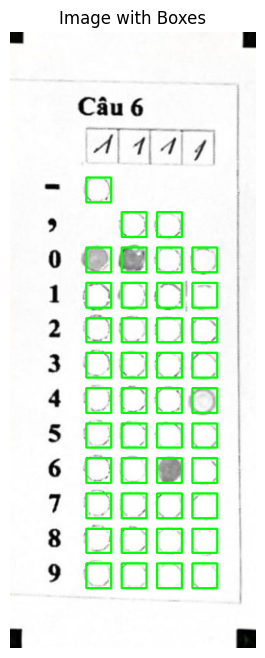

In [62]:
# Input details
start_coord = (0.36, 0.37, 0.1, 0.04)  # Top-left box in YOLO format
grid_size = (10, 4)  # 10 rows, 4 columns
cell_spacing = (0.044, 0.017)  # Spacing in YOLO format (relative to width/height)

# Generate grid coordinates
yolo_boxes = generate_grid_coordinates(start_coord, grid_size, cell_spacing)
yolo_boxes.append((0.36, 0.37-(0.04+0.017)*2, 0.1, 0.04))
yolo_boxes.append((0.36+(0.1+0.044), 0.37-(0.04+0.017), 0.1, 0.04))
yolo_boxes.append((0.36+(0.1+0.044)*2, 0.37-(0.04+0.017), 0.1, 0.04))

# Draw boxes and visualize with matplotlib
draw_boxes_with_matplotlib(output_cut_path, yolo_boxes, output_annote_path)

size_x = x_max - x_min
size_y = y_max - y_min
for box in yolo_boxes:
  final_coordinate.append((x_min + size_x*box[0], y_min + size_y*box[1], int(box[2]*(size_x)), box[3]*size_y))

# Test

In [64]:
import cv2

def draw_rectangles(image_path, yolo_boxes, output_image_path):
    """
    Vẽ các hình chữ nhật dựa trên tọa độ YOLO (giá trị pixel) trên ảnh.

    Parameters:
        image_path (str): Đường dẫn tới ảnh gốc.
        yolo_boxes (list): Danh sách tọa độ YOLO [(center_x, center_y, width, height), ...] với giá trị pixel.
        output_image_path (str): Đường dẫn lưu ảnh kết quả.

    Returns:
        None: Lưu ảnh đã được chỉnh sửa tại `output_image_path`.
    """
    # Load ảnh
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Cannot load image: {image_path}")

    for box in yolo_boxes:
        center_x, center_y, width, height = box

        # Tính tọa độ 4 đỉnh từ tọa độ YOLO
        x_min = int(center_x - width / 2)
        y_min = int(center_y - height / 2)
        x_max = int(center_x + width / 2)
        y_max = int(center_y + height / 2)

        # Vẽ hình chữ nhật
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)

    # Lưu ảnh kết quả
    cv2.imwrite(output_image_path, image)

# Ví dụ sử dụng
image_path = "Image/sheet_rotate.jpg"
rectangles = final_coordinate
output_image_path = "Image/test2.jpg"

draw_rectangles(image_path, rectangles, output_image_path)
print(f"Ảnh kết quả được lưu tại: {output_image_path}")


Ảnh kết quả được lưu tại: Image/test2.jpg


In [65]:
print(final_coordinate[:5])

[(1607.235, 476.2, 29, 31.0), (1645.3, 476.2, 29, 31.0), (1683.365, 476.2, 29, 31.0), (1721.43, 476.2, 29, 31.0), (1759.495, 476.2, 29, 31.0)]


In [66]:
print(width, height)

2255 3151


In [69]:
def convert_to_yolo_format(bboxes, img_width, img_height):
    """
    Convert bounding boxes to YOLO format.

    Parameters:
        bboxes (list of tuples): List of bounding boxes in (center_x, center_y, width, height) format (in pixels).
        img_width (int): Width of the image (in pixels).
        img_height (int): Height of the image (in pixels).
    Returns:
        list of lists: List of bounding boxes in YOLO format.
    """
    yolo_bboxes = []
    for bbox in bboxes:
        center_x, center_y, width, height = bbox
        # Normalize the values
        center_x_normalized = center_x / img_width
        center_y_normalized = center_y / img_height
        width_normalized = width / img_width
        height_normalized = height / img_height
        # Add to the YOLO formatted list
        yolo_bboxes.append((center_x_normalized, center_y_normalized, width_normalized, height_normalized))
    return yolo_bboxes

In [70]:
yolo_bboxes = convert_to_yolo_format(final_coordinate, width, height)
print(yolo_bboxes)

[(0.7127427937915742, 0.151126626467788, 0.012860310421286032, 0.009838146620120596), (0.7296230598669623, 0.151126626467788, 0.012860310421286032, 0.009838146620120596), (0.7465033259423504, 0.151126626467788, 0.012860310421286032, 0.009838146620120596), (0.7633835920177384, 0.151126626467788, 0.012860310421286032, 0.009838146620120596), (0.7802638580931264, 0.151126626467788, 0.012860310421286032, 0.009838146620120596), (0.7971441241685144, 0.151126626467788, 0.012860310421286032, 0.009838146620120596), (0.7127427937915742, 0.16824500158679784, 0.012860310421286032, 0.009838146620120596), (0.7296230598669623, 0.16824500158679784, 0.012860310421286032, 0.009838146620120596), (0.7465033259423504, 0.16824500158679784, 0.012860310421286032, 0.009838146620120596), (0.7633835920177384, 0.16824500158679784, 0.012860310421286032, 0.009838146620120596), (0.7802638580931264, 0.16824500158679784, 0.012860310421286032, 0.009838146620120596), (0.7971441241685144, 0.16824500158679784, 0.0128603104

In [72]:
# Thêm class 0 vào đầu mỗi tuple
yolo_coordinates_with_class = [(0, *coords) for coords in yolo_bboxes]

# Write to txt
with open(output_file, "w") as file:
    for coords in yolo_coordinates_with_class:
        line = " ".join(map(str, coords))
        file.write(line + "\n")

print(f"Dữ liệu đã được ghi vào file {output_file}.")

Dữ liệu đã được ghi vào file yolo_coordinates.txt.
